In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [2]:
base_dir = 'R:\Deep_Learning\Tensorflow\Kurs\Flying Vehicles\data\planes'
raw_number_of_files = {}
classes = ['drone' , 'fighter-jet' , 'helicopter' , 'missile' , 'passager-plane' , 'rocket']
for dir in classes:
    try:
        # Try to list files in the directory and count them.
        raw_number_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))
    except FileNotFoundError:
        # Handle the case where the directory does not exist.
        print(f"Directory '{dir}' not found in {base_dir}")

# Output the result.
print(raw_number_of_files.items())

Directory 'passager-plane' not found in R:\Deep_Learning\Tensorflow\Kurs\Flying Vehicles\data\planes
dict_items([('drone', 1333), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('rocket', 1186)])


In [3]:
data_dir = './images'
if not os.path.exists(data_dir): # creating directory images
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir , 'train')
valid_dir = os.path.join(data_dir , 'test')
test_dir = os.path.join(data_dir , 'valid')

train_drone_dir = os.path.join(train_dir , 'drone')
train_passenger_dir = os.path.join(train_dir , 'passenger')

test_drone_dir = os.path.join(test_dir , 'drone')
test_passenger_dir = os.path.join(test_dir , 'passenger')

valid_drone_dir = os.path.join(valid_dir , 'drone')
valid_passenger_dir = os.path.join(valid_dir , 'passenger')

for dir in (train_dir , valid_dir , test_dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

dirs = [train_drone_dir , train_passenger_dir , valid_drone_dir , valid_passenger_dir , test_drone_dir , test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)

In [4]:
drone_frames = os.listdir(os.path.join(base_dir , 'drone'))
passenger_frames = os.listdir(os.path.join(base_dir , 'passenger-plane'))

drone_frames = [fname for fname in drone_frames if fname.split('.')[1].lower() in ['jpg' , 'png' , 'jpeg']]
passenger_frames = [fname for fname in passenger_frames if fname.split('.')[1].lower() in ['jpg' , 'png' , 'jpeg']]

In [5]:
size = min(len(drone_frames) , len(passenger_frames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [6]:
for i, fname in enumerate(drone_frames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_frames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst) 

print('drone - train', len(os.listdir(train_drone_dir)))
print('drone - valid', len(os.listdir(valid_drone_dir)))
print('drone - test', len(os.listdir(test_drone_dir)))

print('passenger - train', len(os.listdir(train_passenger_dir)))
print('passenger - valid', len(os.listdir(valid_passenger_dir)))
print('passenger - test', len(os.listdir(test_passenger_dir))) 

drone - train 919
drone - valid 262
drone - test 131
passenger - train 919
passenger - valid 262
passenger - test 131


# Data Visualization

(-0.5, 1023.5, 681.5, -0.5)

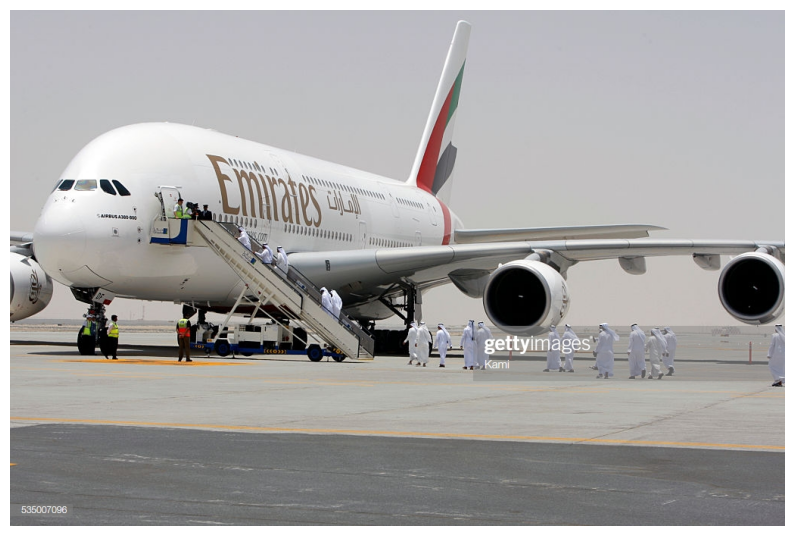

In [7]:
idx = 344 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_frames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False) 

(-0.5, 999.5, 666.5, -0.5)

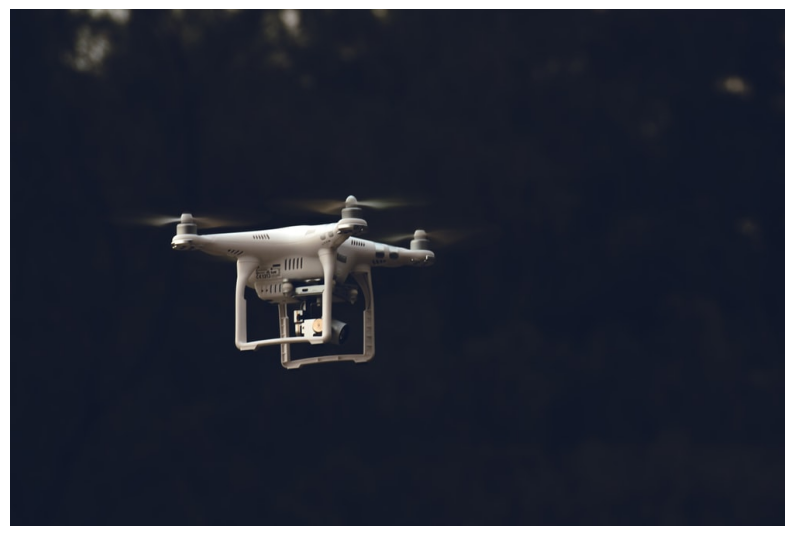

In [8]:
idx = 344
names_mapping = dict(enumerate(drone_frames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False) 

# Data augmentation

In [7]:
BATCH_SIZE = 64
IMAGE_SIZE = 150
train_datagen = ImageDataGenerator(rotation_range=40,      # Random rotation within 40 degrees
                                  rescale= 1.0/255,        # Rescale pixel values to [0, 1]
                                  width_shift_range=0.2,   # Random horizontal shift by 20% of image width
                                  height_shift_range=0.2,  # Random vertical shift by 20% of image height
                                  shear_range=0.2,         # Random shear range from 80% to 120%
                                  zoom_range=0.2,          # Random zoom range  80% to 120%
                                  horizontal_flip=True,    # Random horizontal flipping
                                  vertical_flip = True,    # Random vertical flipping
                                  fill_mode='nearest'      # Fill mode for new pixels after shifts/rotations
                    )

valid_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen  = ImageDataGenerator(rescale=1.0/255) 

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(IMAGE_SIZE,IMAGE_SIZE), # Target image size
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary'
                                                   )

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary'
                                                   )

test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                   target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='binary',
                                                   shuffle=False
                                                   )

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.
Found 262 images belonging to 2 classes.


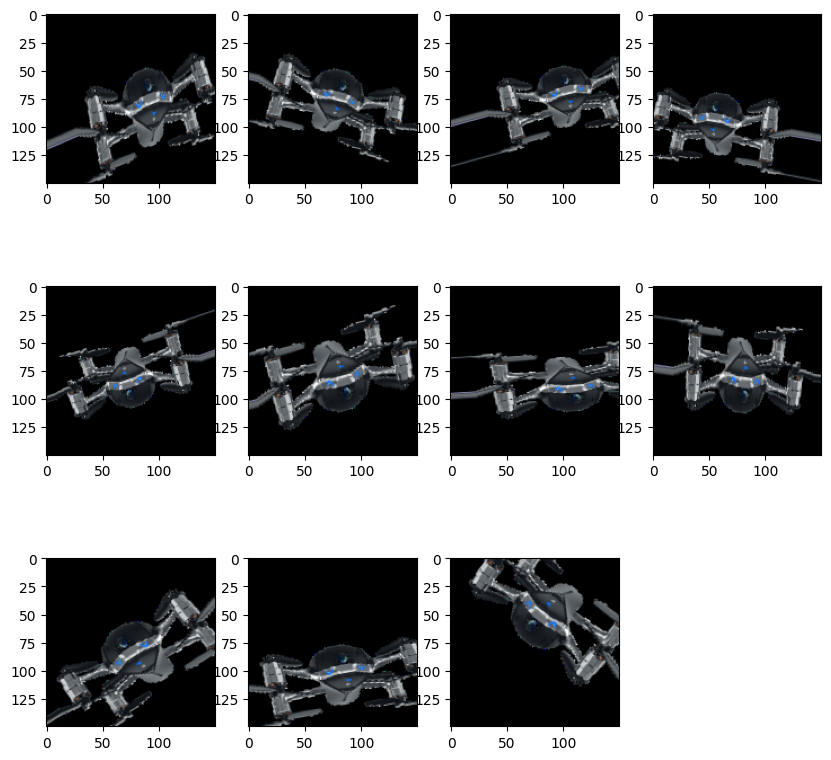

In [8]:
frames = [os.path.join(train_drone_dir , i) for i in os.listdir(train_drone_dir)]
img_path = frames[44]
img = image.load_img(img_path, target_size=(150,150))

x = image.img_to_array(img)  # Convert image to NumPy array
x = np.expand_dims(x, axis=0)  # Add new dimension at the begining to obtain shape (1, 150 ,150, 3)

iterator = train_datagen.flow(x, batch_size=1)

plt.figure(figsize=(10,10))

for i in range(1, 12):
    plt.subplot(3, 4, i)
    batch = iterator.next()
    plt.imshow(image.array_to_img(batch[0]))  # Show processed image

plt.show()

# Build the model

In [14]:
model = Sequential()
model.add(layers.Conv2D(filters=32 , kernel_size=(3 , 3) ,activation='relu' , input_shape = (150, 150 , 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(filters=64 , kernel_size=(3,3) , activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(filters=128 , kernel_size=(3,3) , activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(filters=256 , kernel_size=(3,3) , activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(units=512 , activation='relu'))
model.add(layers.Dense(units=1 , activation='sigmoid')) 
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 17, 17, 128)      

In [18]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001) , loss='binary_crossentropy' , metrics=['accuracy'] )

In [19]:
tensorboard = TensorBoard(log_dir='logs')
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE

In [20]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              callbacks=[tensorboard],
                              epochs=30,
                              validation_data=valid_generator,
                              validation_steps=validation_steps              
                             )

Epoch 1/30


14/14 [==============================] - 19s 1s/step - loss: 0.7376 - accuracy: 0.4877 - val_loss: 0.6927 - val_accuracy: 0.5117
Epoch 2/30
14/14 [==============================] - 13s 936ms/step - loss: 0.6915 - accuracy: 0.5125 - val_loss: 0.6934 - val_accuracy: 0.5039
Epoch 3/30
14/14 [==============================] - 12s 888ms/step - loss: 0.6920 - accuracy: 0.5312 - val_loss: 0.6837 - val_accuracy: 0.5273
Epoch 4/30
14/14 [==============================] - 13s 904ms/step - loss: 0.6928 - accuracy: 0.5501 - val_loss: 0.6882 - val_accuracy: 0.5547
Epoch 5/30
14/14 [==============================] - 12s 823ms/step - loss: 0.7051 - accuracy: 0.6048 - val_loss: 0.6959 - val_accuracy: 0.4492
Epoch 6/30
14/14 [==============================] - 12s 891ms/step - loss: 0.6941 - accuracy: 0.5145 - val_loss: 0.6854 - val_accuracy: 0.5625
Epoch 7/30
14/14 [==============================] - 13s 931ms/step - loss: 0.6846 - accuracy: 0.5491 - val_loss: 0.6581 - val_accuracy: 0.5820


# Transfer learning - model VGG16

In [19]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet' ,include_top=False , input_shape=(150 ,150 , 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [20]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256 , activation='relu'))
model.add(layers.Dense(units=1 , activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               2097408   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
print(f'Numbers of layers before before frezzing: {len(model.trainable_weights)}')
conv_base.trainable = False
print(f'Numbers of layers after before frezzing: {len(model.trainable_weights)}')

Numbers of layers before before frezzing: 30
Numbers of layers after before frezzing: 4


In [23]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.001) , loss = 'binary_crossentropy' , metrics=['accuracy'])

In [24]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator,
                              validation_steps=validation_steps,
                              callbacks=[tensorboard],
                              epochs=50
                             )

Epoch 1/50


14/14 [==============================] - 28s 2s/step - loss: 1.5834 - accuracy: 0.5848 - val_loss: 0.7055 - val_accuracy: 0.5352
Epoch 2/50
14/14 [==============================] - 23s 2s/step - loss: 0.5910 - accuracy: 0.6864 - val_loss: 0.6106 - val_accuracy: 0.6719
Epoch 3/50
14/14 [==============================] - 22s 2s/step - loss: 0.5459 - accuracy: 0.7143 - val_loss: 0.6024 - val_accuracy: 0.6758
Epoch 4/50
14/14 [==============================] - 22s 2s/step - loss: 0.5323 - accuracy: 0.7221 - val_loss: 0.5835 - val_accuracy: 0.6914
Epoch 5/50
14/14 [==============================] - 22s 2s/step - loss: 0.5468 - accuracy: 0.7310 - val_loss: 0.5743 - val_accuracy: 0.7070
Epoch 6/50
14/14 [==============================] - 22s 2s/step - loss: 0.4902 - accuracy: 0.7545 - val_loss: 0.6705 - val_accuracy: 0.6172
Epoch 7/50
14/14 [==============================] - 22s 2s/step - loss: 0.4872 - accuracy: 0.7612 - val_loss: 0.6220 - val_accuracy: 0.6875
Epoch 8/50
14/14 [

In [26]:
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_2       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [27]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
print_layers(conv_base)

layer_name: input_2       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [28]:
model3 = Sequential()
model3.add(conv_base)
model3.add(layers.Flatten())
model3.add(layers.Dense(units=256 , activation='relu'))
model3.add(layers.Dense(units=1 , activation='sigmoid'))
model3.compile(optimizer=optimizers.RMSprop(learning_rate=0.001) , loss = 'binary_crossentropy' , metrics=['accuracy'])
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2097408   
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 9177089 (35.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


# Testing our Model

In [29]:
# Predict probabilities on the test dataset
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1) 

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_pred, y_true)

print(conf_matrix)
print(classification_report(y_true, y_pred))

5/5 [==============================] - 2s 283ms/step
[[89 42]
 [42 89]]
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       131
           1       0.68      0.68      0.68       131

    accuracy                           0.68       262
   macro avg       0.68      0.68      0.68       262
weighted avg       0.68      0.68      0.68       262

